## Spotify's Next Top Model

#### Here we will be hosting a modeling competition that will determine which model deserves to leave this course as Spotify's Next Top Model.


Best of luck to all the contestents! We wish you well, but only the best will rise to the top. There are no participation medals in this game, honey.

In [72]:
# imports  NOTE: Dependent on Pandas 21.0
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from gensim.models.word2vec import Word2Vec, KeyedVectors
import html
import re
import itertools
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import cdist

sns.set_context('paper')
sns.set_palette('muted',color_codes=True)
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Get the data 
df_trk = utils.make_working_df()
df_trk.head()

,trk_added_at,art_name,trk_duration,explicit,trk_id,trk_name,pl_id,trk_popularity,artist_followers,artist_genre,...,pl_min_trkpop,pl_max_trkpop,pl_mean_trkpop,art_min_trkpop,art_max_trkpop,art_mean_trkpop,art_total_trks,art_class,user_pls_in_sample,pl_desc_chars
0,2013-09-30 16:12:24,Allgott & Villgott,119907.0,0.0,3aIptaHMnbIXRxPWKlqwc6,Klappa lamm,3ftsSOkyCsILZeAZYQr2jH,2.0,76.0,None,...,0.0,4.0,1.333333,0.0,6.0,1.764706,13,crap_factory,515,0
1,2013-10-05 15:22:13,Allgott & Villgott,67918.0,0.0,0rPBlDWP6wcfax63Vs8nAF,Hej på dej,3ftsSOkyCsILZeAZYQr2jH,4.0,76.0,None,...,0.0,4.0,1.333333,0.0,6.0,1.764706,13,crap_factory,515,0
2,2014-07-16 13:50:24,J Boog,217270.0,0.0,4RjHalDdUreXDJSJLo44lK,Sunshine Girl,35XFuuqgCvTYQARix7CFpm,53.0,103793.0,[polynesian pop],...,0.0,72.0,38.269231,0.0,58.0,38.419355,20,star,166,0
3,2014-07-06 09:12:01,Brennan Heart,222919.0,0.0,6A04TZRVZw8db1VsHeYOEx,Never Break Me - Toneshifterz Remix,0gGfciue2ZDCOG5uMv46gU,0.0,122496.0,[hardstyle],...,0.0,58.0,15.510000,0.0,47.0,11.272727,18,crap_factory,166,0
4,2012-06-29 11:53:52,Johnny Ray,153375.0,0.0,1k4p7c69Dkh2b7s813ooR8,"Yes Tonight, Josephine",6Tuex6CIDfZRyRtsmb5rwE,0.0,1281.0,None,...,0.0,0.0,0.000000,0.0,0.0,0.000000,1,garage_band,1731,0


In [5]:
# Drop these columns because we dont need them for anything in modeling or EDA
df_trk = df_trk.drop(['pl_desc','pl_name','celeb_name'],axis=1)

In [7]:
df_trk.columns

Index(['trk_added_at', 'art_name', 'trk_duration', 'explicit', 'trk_id',
       'trk_name', 'pl_id', 'trk_popularity', 'artist_followers',
       'artist_genre', 'artist_id', 'artist_pop', 'collab', 'pl_followers',
       'pl_num_trks', 'pl_owner', 'cluster', 'cluster_norm', 'is_celeb',
       'user_followers', 'pl_first_date', 'pl_last_date', 'pl_days_active',
       'pl_days_old', 'pl_num_trk', 'pl_num_art', 'pl_min_trkpop',
       'pl_max_trkpop', 'pl_mean_trkpop', 'art_min_trkpop', 'art_max_trkpop',
       'art_mean_trkpop', 'art_total_trks', 'art_class', 'user_pls_in_sample',
       'pl_desc_chars'],
      dtype='object')

## EDA:

We explore the data (and our engineered features) at both the track and the playlist level.  As we can see below, we have about 9.7 playlists per user when we include all users. Below, when we drop playlists with below 1 follower, we have about 4.4 playlists per user.  Likewise, we start with ~368k tracks and after we drop the playlists with fewer than 1 follower we only have ~211k tracks remaining.

In [53]:
print('We have {} unique spotify users.'.format(len(df_trk['pl_owner'].unique())))
print('We have {} unique spotify playlists.'.format(len(df_trk['pl_id'].unique())))


We have 779 unique spotify users.
We have 3422 unique spotify playlists.


In [8]:
# Make a playlist data subset as we'll use this often for EDA.  

df_pl_columns = ['pl_id', 'pl_days_old', 
                 'pl_days_active', 'pl_num_trk', 'pl_num_art', 
                 'pl_min_trkpop', 'pl_max_trkpop', 'pl_mean_trkpop', 
                 'pl_followers', 'pl_num_trks','pl_desc_chars'] 

df_pl = df_trk.groupby('pl_id').first().reset_index()[df_pl_columns]

In [10]:
print("Master DF has total of {0} rows/tracks (including zero followers)".format(df_trk.shape[0]))

# Cut out the zero- and one- follower playlists
# Cutting one-follower playlists because it's likely just an individual following their own list
df_trk = df_trk[df_trk['pl_followers'] > 1]
print("Master DF has total of {0} rows/tracks (after removing zero followers) \n".format(df_trk.shape[0]))

Master DF has total of 367911 rows (including zero followers)
Master DF has total of 210798 rows (after removing zero followers) 



In [54]:
print('We have {} unique spotify users with a playlist with > 1 follower.'.format(len(df_trk['pl_owner'].unique())))
print('We have {} unique spotify playlists with > 1 follower.'.format(len(df_trk['pl_id'].unique())))

We have 779 unique spotify users with a playlist with > 1 follower.
We have 3422 unique spotify playlists with > 1 follower.


#### Playlist followers:
Engineering   more   features   around   artist and   playlist   data   yielded   interesting relationships.   A   cursory   measure   of   playlist success,   our   generalized   project   goal,   is the   number   of   followers   per   playlist.   The histograms   to   the   right   show   a   significant right-skew,   with   most   playlists   having   few followers   and   a   few   approaching   the   1M mark.   The   log-transform   of   followers illustrates   a   potentially   more   useful response   variable.

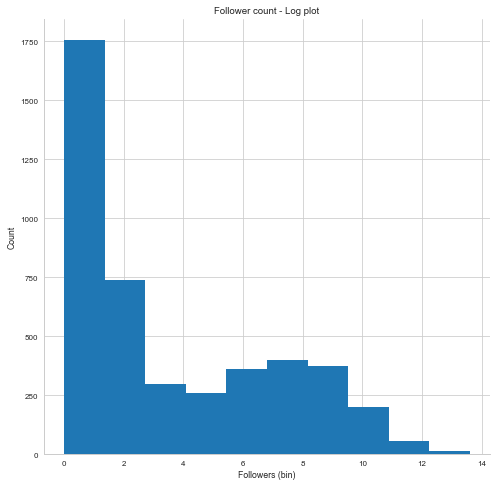

In [19]:
# Plot histogram of follower counts for each playlist
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(np.log(df_pl[df_pl['pl_followers']>0].pl_followers))
ax.set_title("Follower count - Log plot")
ax.set_xlabel("Followers (bin)")
ax.set_ylabel("Count")
sns.despine()

##### Artist analysis:

We   separated   artists   into   five   distinct   categories   using   combinations   of   their   mean   popularity   and   total   number   of   tracks   as follows:    superstar ,     star ,     one_hit_wonder ,   g   arage_band ,    and     trash_factory .
These   categories   should   be   self-descriptive,   but   the   two   plots   below   do   a   fantastic   job   of   illustrating   each   in   terms   of   their thresholds   and   relationships.      The   artist   popularity   metric   ties   out   with   our   expectations   because   we   see   people   like   Post Malone,   Camila   Cabello,   and   Ed   Sheeran   in   our   superstar   category.

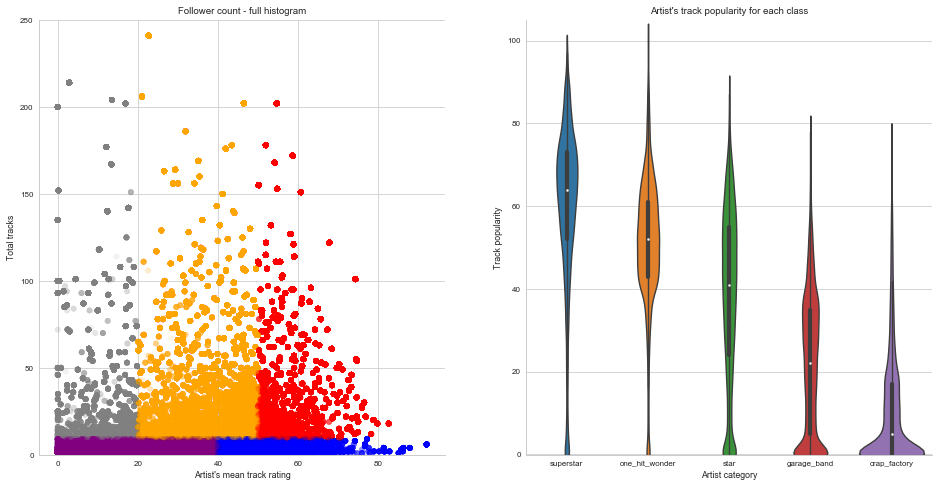

In [60]:
# Plot follower count vs. average track popularity
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))

colors = {'superstar':'red', 'star':'orange', 'trash_factory':'grey', 'one_hit_wonder':'blue', 'garage_band':'purple'}

ax1.scatter(df_trk.art_mean_trkpop, df_trk.art_total_trks, alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax1.set_title("Follower count - full histogram")
ax1.set_xlabel("Artist's mean track rating")
ax1.set_ylabel("Total tracks")
ax1.set_ylim((0,250))

order = ['superstar','one_hit_wonder','star','garage_band','trash_factory']

sns.violinplot(data=df_trk, y='trk_popularity',x='art_class',order=order,ax=ax2)
ax2.set_title("Artist's track popularity for each class")
ax2.set_xlabel("Artist category")
ax2.set_ylabel("Track popularity")
ax2.set_ylim((-0.1, 105))

sns.despine(top = True, right = True)

#### Continuing Artist Analysis:
Comparing   these   five   artist   categories   with   specific   track popularities   (as   determined   by   Spotify)   and   those   tracks’ playlists’   followers   shows   us   that   not   only   do   most   playlists incorporate   popular   artists   (red/orange),   but   a   lot   of   them   have the   “superstar”   artists’   best   songs   (the   mostly   red   right   side),   as well   as   a   smattering   of   “one-hit-wonders”   (blue   in   the   middle) and   a   dense   area   of   moderately   popular   songs   throughout (between   30   and   70   popularity).   This   relationship   and   playlist architecture   should   also   be   intuitive,   and   the   scatterplot   below   illustrates   it   well.

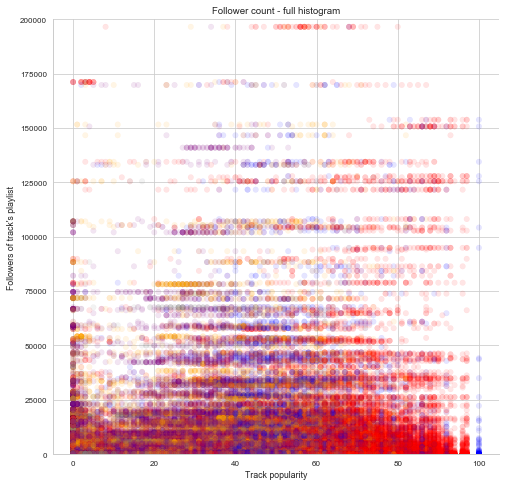

In [20]:
# Plot follower count vs. average track popularity
fig, ax = plt.subplots(figsize = (8,8))

colors = {'superstar':'red', 'star':'orange', 'crap_factory':'grey', 'one_hit_wonder':'blue', 'garage_band':'purple'}

ax.scatter(df_trk['trk_popularity'], df_trk['pl_followers'], alpha = 0.1, c=df_trk['art_class'].apply(lambda x: colors[x]))
ax.set_title("Follower count - full histogram")
ax.set_xlabel("Track popularity")
ax.set_ylabel("Followers of track's playlist")
ax.set_ylim((0,200000))
sns.despine(top = True, right = True)

##### Time and playlists
It   appears   that   there   may   be   a   relationship   between   the   number of   tracks   a   playlist   has   and   its   number   of   followers   (top-left),   as well   as   length   of   its   description (top-right).  We   also   investigated   the   impact   of   playlist   turnover   rate,   or   relative   age, days   between   the   oldest   and   newest   track   being added (bottom-left),   as   well   as   the  age of the oldest song   on   playlist   follower   count   (bottom-right).

(0, 500)

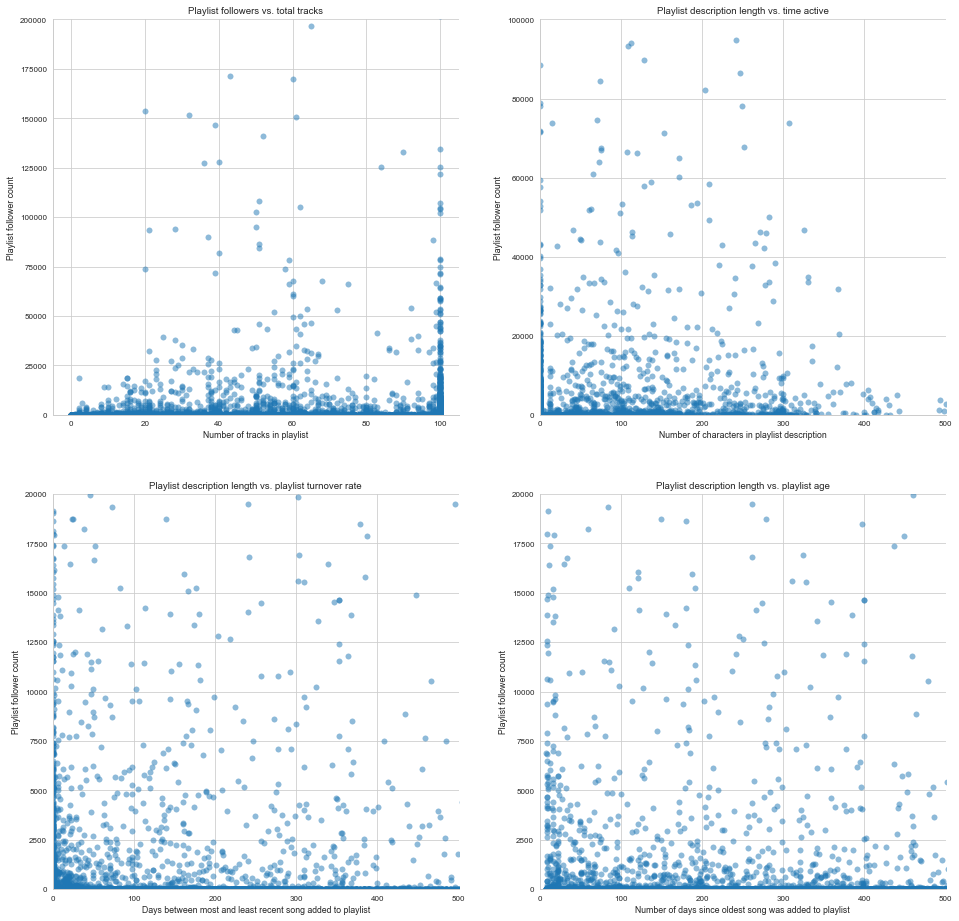

In [58]:
# Test if bigger playlists have more followers
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize = (16,16))
ax1.scatter(df_pl.pl_num_trk, df_pl.pl_followers, alpha = 0.5)
ax1.set_title("Playlist followers vs. total tracks")
ax1.set_xlabel("Number of tracks in playlist")
ax1.set_ylabel("Playlist follower count")
ax1.set_ylim((0,200000))

ax2.scatter(df_pl.pl_desc_chars, df_pl.pl_followers, alpha = 0.5)
ax2.set_title("Playlist description length vs. time active")
ax2.set_xlabel("Number of characters in playlist description")
ax2.set_ylabel("Playlist follower count")
ax2.set_ylim((0,100000))
ax2.set_xlim((0,500))

ax3.scatter(df_pl.pl_days_active, df_pl.pl_followers, alpha = 0.5)
ax3.set_title("Playlist description length vs. playlist turnover rate")
ax3.set_xlabel("Days between most and least recent song added to playlist")
ax3.set_ylabel("Playlist follower count")
ax3.set_ylim((0,20000))
ax3.set_xlim((0,500))

ax4.scatter(df_pl.pl_days_old, df_pl.pl_followers, alpha = 0.5)
ax4.set_title("Playlist description length vs. playlist age")
ax4.set_xlabel("Number of days since oldest song was added to playlist")
ax4.set_ylabel("Playlist follower count")
ax4.set_ylim((0,20000))
ax4.set_xlim((0,500))

sns.despine(top = True, right = True)

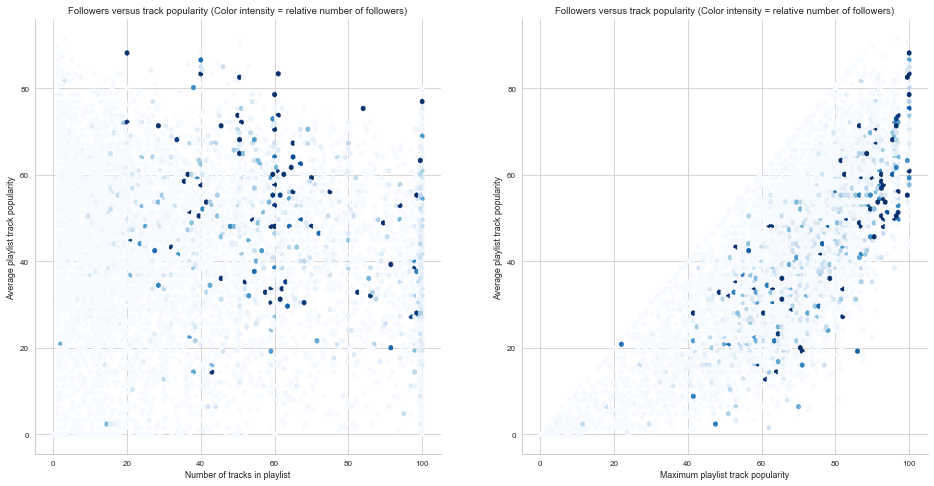

In [59]:
# Test playlist mean/max popularity versus follower count
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,8))
ax1.hexbin(df_pl.pl_num_trk, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 100, vmax=35000)
ax1.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax1.set_xlabel("Number of tracks in playlist")
ax1.set_ylabel("Average playlist track popularity")

ax2.hexbin(df_pl.pl_max_trkpop, df_pl.pl_mean_trkpop, C=df_pl.pl_followers, cmap='Blues', gridsize = 100, vmax=25000)
ax2.set_title("Followers versus track popularity (Color intensity = relative number of followers)")
ax2.set_xlabel("Maximum playlist track popularity")
ax2.set_ylabel("Average playlist track popularity")
sns.despine(top = True, right = True)

In [62]:
# Blow out the dataframe by genre
df_trk['artist_genre'] = [g if type(g)==list else [] for g in df_trk['artist_genre']]
bigdf = utils.explode_value(df_trk[['artist_genre','pl_followers','artist_pop']],'artist_genre')

In [74]:
genres_by_artist_pop = bigdf[['artist_genre','artist_pop']].groupby('artist_genre',as_index=False\
                                                    ).mean().sort_values('artist_pop',ascending=False).head(15)
genres_by_pl_followers = bigdf[['artist_genre','pl_followers']].groupby('artist_genre',as_index=False\
                                                    ).median().sort_values('pl_followers',ascending=False).head(15)

##### Genres: 

Here we see some of the genres that show up in the most popular playlists by followers.  The barplot directly below is by the median number of playlist followers, so as to be less sensitive to outliers.  The barplot below this one is based on mean artist popularity by genre. As we can see, there are some specific genres at the top that we would usually associate with one artist (canadian pop - Justin Bieber, detroit hip hop - Eminem). It is likely those artists are skewing the distribution, since those are their respective genres. Sadly, we do not have enough members of each genre to get a good view of the most popular genres by artist.

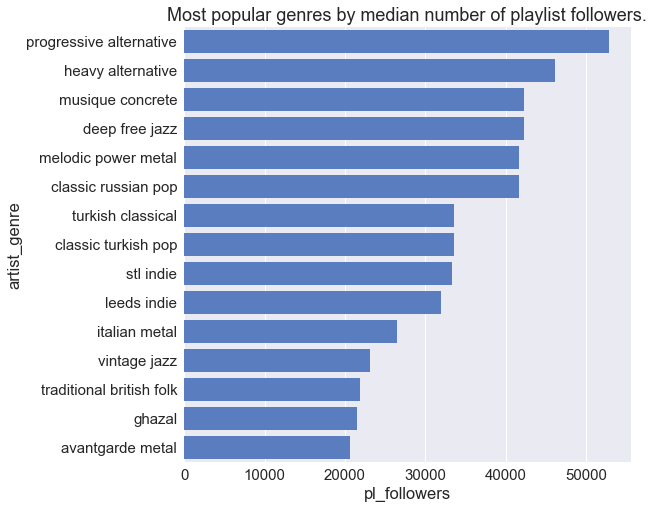

In [85]:
sns.set(font_scale=1.5)
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=genres_by_pl_followers,y='artist_genre',x='pl_followers',color='b',ax=ax)
plt.title('Most popular genres by median number of playlist followers.')

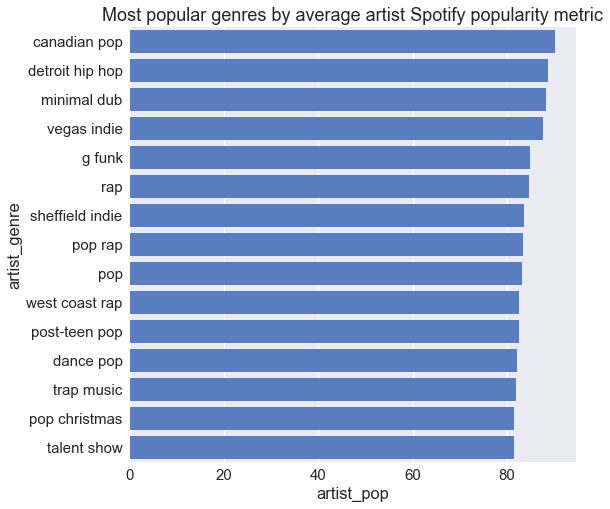

In [86]:
fig,ax = plt.subplots(figsize=(8,8))
sns.barplot(data=genres_by_artist_pop,y='artist_genre',x='artist_pop',color='b',ax=ax)
plt.title('Most popular genres by average artist Spotify popularity metric')

## Merge in the genre features:

We are waiting until now to merge in the genre features to save memory in the above exercises.

In [91]:
genre_features = pd.read_json('data/genre_features.json',compression='gzip')
df_full = pd.merge(df_trk,genre_features,how='left',on='pl_id')

##### More genres?!? 

do more genre stuff

In [ ]:
df_full.head()

In [ ]:
len(df_full['mode_genre'].unique())

In [92]:
df_full.columns

Index(['trk_added_at', 'art_name', 'trk_duration', 'explicit', 'trk_id',
       'trk_name', 'pl_id', 'trk_popularity', 'artist_followers',
       'artist_genre', 'artist_id', 'artist_pop', 'collab', 'pl_followers',
       'pl_num_trks', 'pl_owner', 'cluster', 'cluster_norm', 'is_celeb',
       'user_followers', 'pl_first_date', 'pl_last_date', 'pl_days_active',
       'pl_days_old', 'pl_num_trk', 'pl_num_art', 'pl_min_trkpop',
       'pl_max_trkpop', 'pl_mean_trkpop', 'art_min_trkpop', 'art_max_trkpop',
       'art_mean_trkpop', 'art_total_trks', 'art_class', 'user_pls_in_sample',
       'pl_desc_chars', 'has_alternative', 'has_christmas', 'has_country',
       'has_dance', 'has_deep', 'has_hip', 'has_hop', 'has_house', 'has_indie',
       'has_latin', 'has_metal', 'has_pop', 'has_rap', 'has_rock', 'has_trap',
       'mode_genre', 'no_genre'],
      dtype='object')